In [1]:
import numpy as np
import matplotlib.pyplot as plt

import cv2
from PIL import Image

import os
from os import listdir
from os.path import isfile, join

import string

from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

os.chdir('E:/College/Final Year Project/ufi')
from utils.load_data import load_pathnames

from sift_svm import drawMatches as dm
from sift_svm import extract_descriptors as ed

from tqdm import tqdm_notebook as tqdmn

In [2]:
def sift(img_path):
    img = cv2.imread(img_path, 0)
    orb = cv2.ORB_create()

    # compute the descriptors with ORB
    kp, des = orb.detectAndCompute(img, None)
    
    #img_out = np.asarray(img)
    #img_out = cv2.drawKeypoints(img, kp, img)
    
    #return img_out, kp, des
    return kp, des

img, k, d = sift('data/train/s1/1.pgm')
plt.imshow(img), plt.show()


In [3]:
paths, labels = load_pathnames('data', True)

In [4]:
feature = {}
for i in range(1, 606):
    class_name = 's' + str(i)
    feature[class_name] = {}
for image_path in tqdmn(paths):
    class_name = image_path.split('\\')[2]
    kp, des = sift(image_path)
    image_name = image_path.split('\\')[3]
    feature[class_name][image_name] = des

In [5]:
len(feature)

605

In [6]:
MIN_MATCH_COUNT = 10
FLANN_INDEX_LSH = 6
FLANN_INDEX_KDTREE = 0
index_params = dict(algorithm = FLANN_INDEX_LSH, trees = 5)
search_params = dict(checks=50) 
flann = cv2.FlannBasedMatcher(index_params, search_params)


In [7]:
test_paths, test_labels = load_pathnames('data', False)

In [8]:
correct = 0
c = 0
for test_path, test_label in tqdmn(zip(test_paths, test_labels)):
    c += 1
    kp_test, des_test = sift(test_path)
    
    result = {}
    for class_name in feature.keys():
        ctr = 0
        for filename_train, des_train in feature[class_name].items():
            good = []
            #ctr = 0

            matches = flann.knnMatch(des_train, des_test, k=2)   
            for m_n in matches:
                if len(m_n) != 2:
                    continue
                (m,n) = m_n
                if (m.distance < 0.6*n.distance): #Apply the ratio test as per the paper
                    good.append([m])
                    ctr+=1
        result[class_name] = ctr
        best_match = max(result,key = lambda x: result[x])
    if (best_match.split('-')[0] == ('s' + str(test_label))):
        correct += 1
acc = correct/605
print("Accuracy:", acc)


Accuracy: 0.3487603305785124


In [9]:
best_match.split('-')[0] == ('s' + str(test_labels[0]))

False

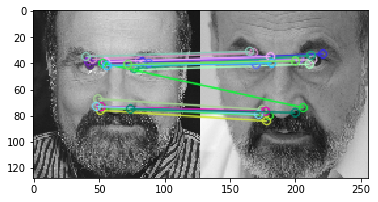

In [10]:
img1 = cv2.imread('data/train/s1/1.pgm',0) # queryImage
img2 = cv2.imread('data/test/s1/3.pgm',0) # trainImage

# Initiate SIFT detector
orb = cv2.ORB_create()

# find the keypoints and descriptors with SIFT
kp1, des1 = orb.detectAndCompute(img1,None)
kp2, des2 = orb.detectAndCompute(img2,None)

# create BFMatcher object
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)

# Match descriptors.
matches = bf.match(des1,des2)

# Sort them in the order of their distance.
matches = sorted(matches, key = lambda x:x.distance)

# Draw first 10 matches.
img3 = cv2.drawMatches(img1,kp1,img2,kp2,matches[:20],None,flags=2)

plt.imshow(img3)
plt.show()